<a href="https://colab.research.google.com/github/jrebull/AnaliticaPrescriptiva/blob/main/MIAAD_Caso5_Cartera_Inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso 5: Optimización de Cartera de Inversión con Riesgo Cuadrático

## Maestría en Inteligencia Artificial y Analítica de Datos (MIAAD)
### Universidad Autónoma de Ciudad Juárez

**Profesor:** Dr. Gilberto Rivera Zarate  
**Alumno:** Javier Augusto Rebull Saucedo  
**Matrícula:** al263483  
**Fecha:** 24 de octubre de 2025

---

## Objetivo

Resolver el problema clásico de optimización de portafolio de Markowitz utilizando **Pyomo** e **IPOPT** para encontrar la asignación óptima de capital entre 20 activos financieros que maximice el rendimiento esperado ajustado por riesgo.

## 1. Instalación y Configuración de Dependencias

En esta celda instalamos las librerías necesarias para resolver el problema de optimización no lineal.

In [1]:
# Instalación de paquetes necesarios
!pip install pyomo --quiet
!pip install numpy pandas matplotlib --quiet

# Instalación del solver IPOPT
# En Google Colab o sistemas Linux:
!apt-get install -y coinor-libipopt1v5 --quiet
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64.zip
!chmod +x ipopt

import os
os.environ['PATH'] += ':/content'  # Agregar IPOPT al PATH

Reading package lists...
Building dependency tree...
Reading state information...
coinor-libipopt1v5 is already the newest version (3.11.9-2.2build5).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
[ipopt-linux64.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of ipopt-linux64.zip or
        ipopt-linux64.zip.zip, and cannot find ipopt-linux64.zip.ZIP, period.
chmod: cannot access 'ipopt': No such file or directory


## 2. Importación de Librerías

Importamos todas las librerías que utilizaremos a lo largo del análisis.

In [2]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Librerías importadas exitosamente")

✓ Librerías importadas exitosamente


In [3]:
# ============================================================
# INSTALACIÓN DE PYOMO E IPOPT PARA GOOGLE COLAB
# ============================================================
# Este script intenta múltiples métodos de instalación para
# asegurar que IPOPT esté disponible en el entorno.
# ============================================================

import sys
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("🔧 Iniciando instalación de Pyomo e IPOPT...\n")

# ------------------------------------------------------------
# MÉTODO 1: Instalar desde repositorios apt (más rápido)
# ------------------------------------------------------------
print("📦 Método 1: Instalando desde repositorios apt...")
!apt-get update -qq > /dev/null 2>&1
!apt-get install -y -qq coinor-libipopt1v5 coinor-libipopt-dev coinor-bonmin > /dev/null 2>&1

# Instalar Pyomo
print("🐍 Instalando Pyomo...")
!pip install -q pyomo

# ------------------------------------------------------------
# VERIFICAR SI IPOPT ESTÁ DISPONIBLE
# ------------------------------------------------------------
print("\n🔍 Verificando instalación de IPOPT...")
ipopt_found = False

# Buscar en PATH
result_which = subprocess.run(['which', 'ipopt'], capture_output=True, text=True)
if result_which.returncode == 0 and result_which.stdout.strip():
    print(f"✅ IPOPT encontrado en PATH: {result_which.stdout.strip()}")
    ipopt_found = True
else:
    # Buscar en todo el sistema
    print("🔍 IPOPT no encontrado en PATH, buscando en el sistema...")
    result_find = subprocess.run(['find', '/usr', '-name', 'ipopt', '-type', 'f', '2>/dev/null'],
                                 capture_output=True, text=True, shell=False)

    if result_find.stdout:
        ipopt_path = result_find.stdout.strip().split('\n')[0]
        print(f"✅ IPOPT encontrado en: {ipopt_path}")
        # Agregar al PATH
        os.environ['PATH'] = os.path.dirname(ipopt_path) + ':' + os.environ['PATH']
        ipopt_found = True

# ------------------------------------------------------------
# MÉTODO 2: Instalar con micromamba (si método 1 falló)
# ------------------------------------------------------------
if not ipopt_found:
    print("\n⚠️  Método apt falló. Intentando con micromamba...")

    # Quitar repos problemáticos
    !sed -i '/r2u.stat.illinois.edu/ s/^/#/' /etc/apt/sources.list 2>/dev/null || true
    !sed -i '/r2u.stat.illinois.edu/ s/^/#/' /etc/apt/sources.list.d/* 2>/dev/null || true

    # Instalar micromamba
    print("📦 Descargando micromamba...")
    !wget -qO- https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba > /dev/null 2>&1

    # Crear entorno con ipopt
    print("🔧 Creando entorno conda con IPOPT...")
    !./bin/micromamba create -y -p /usr/local/ipopt-env -c conda-forge ipopt pyomo > /dev/null 2>&1

    # Exponer el ejecutable
    !ln -sf /usr/local/ipopt-env/bin/ipopt /usr/bin/ipopt 2>/dev/null || true

    # Verificar nuevamente
    result_final = subprocess.run(['which', 'ipopt'], capture_output=True, text=True)
    if result_final.returncode == 0:
        print(f"✅ IPOPT instalado exitosamente: {result_final.stdout.strip()}")
        ipopt_found = True

# ------------------------------------------------------------
# VERIFICACIÓN FINAL Y PRUEBA CON PYOMO
# ------------------------------------------------------------
print("\n" + "="*60)
print("        VERIFICACIÓN FINAL DE INSTALACIÓN")
print("="*60)

# Verificar versión de IPOPT
if ipopt_found:
    print("\n📋 Información de IPOPT:")
    !ipopt -v 2>/dev/null || echo "   Instalado pero versión no disponible"

# Probar con Pyomo
print("\n🧪 Probando disponibilidad en Pyomo...")
try:
    import pyomo.environ as pyo

    # Probar IPOPT
    solver_ipopt = pyo.SolverFactory('ipopt')
    if solver_ipopt.available():
        print("   ✅ IPOPT disponible en Pyomo")
    else:
        print("   ⚠️  IPOPT no disponible en Pyomo (intentando alternativas)")

    # Verificar solvers alternativos
    solvers_disponibles = []
    for solver_name in ['ipopt', 'bonmin', 'couenne', 'baron']:
        try:
            solver = pyo.SolverFactory(solver_name)
            if solver.available():
                solvers_disponibles.append(solver_name)
        except:
            pass

    if solvers_disponibles:
        print(f"\n🎯 Solvers NLP disponibles: {', '.join(solvers_disponibles)}")
    else:
        print("\n❌ No se encontraron solvers NLP disponibles")
        print("💡 Sugerencia: El código usará fallback a métodos alternativos")

except Exception as e:
    print(f"   ❌ Error al verificar Pyomo: {e}")

import pyomo.environ as pyo
import numpy as np


print("\n" + "="*60)
print("✅ Instalación completada")
print("="*60)

🔧 Iniciando instalación de Pyomo e IPOPT...

📦 Método 1: Instalando desde repositorios apt...
🐍 Instalando Pyomo...

🔍 Verificando instalación de IPOPT...
🔍 IPOPT no encontrado en PATH, buscando en el sistema...

⚠️  Método apt falló. Intentando con micromamba...
📦 Descargando micromamba...
🔧 Creando entorno conda con IPOPT...
✅ IPOPT instalado exitosamente: /usr/bin/ipopt

        VERIFICACIÓN FINAL DE INSTALACIÓN

📋 Información de IPOPT:
Ipopt 3.14.19 (Linux x86_64), ASL(20231111)



Failed to set executable for solver asl. File with name=bonmin either does not exist or it is not executable. To skip this validation, call set_executable with validate=False.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pyomo/opt/base/solvers.py", line 175, in __call__
    opt = self._cls[_implicit_solvers[mode]](**kwds)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pyomo/solvers/plugins/solvers/ASL.py", line 46, in __init__
    SystemCallSolver.__init__(self, **kwds)
  File "/usr/local/lib/python3.12/dist-packages/pyomo/opt/solver/shellcmd.py", line 66, in __init__
    self.set_executable(name=executable, validate=validate)
  File "/usr/local/lib/python3.12/dist-packages/pyomo/opt/solver/shellcmd.py", line 115, in set_executable
    raise ValueError(
ValueError: Failed to set executable for solver asl. File with name=bonmin either does not exist or it is not executable. To skip this validatio


🧪 Probando disponibilidad en Pyomo...
   ✅ IPOPT disponible en Pyomo

🎯 Solvers NLP disponibles: ipopt

✅ Instalación completada


## 3. Carga de Datos

Cargamos los rendimientos esperados y la matriz de covarianza de los 20 activos financieros desde archivos CSV.

In [45]:
# Cargar rendimientos esperados
# NOTA: Ajustar la ruta según la ubicación de los archivos
df_rendimientos = pd.read_csv('Rendimientos_Esperados_Portafolio.csv')
print("Rendimientos Esperados (primeros 10 activos):")
print(df_rendimientos.head(20))
print(f"\nTotal de activos: {len(df_rendimientos)}")

# Cargar matriz de covarianza
df_covarianza = pd.read_csv('Matriz_Covarianza_Portafolio(6).csv', index_col=0)
print("\nDimensiones de la matriz de covarianza:", df_covarianza.shape)
print("\nPrimeras 5 filas y columnas de la matriz de covarianza:")
print(df_covarianza.iloc[:10, :10])

Rendimientos Esperados (primeros 10 activos):
   Acción  Rendimiento Esperado (%)
0      A1                     10.62
1      A2                     19.26
2      A3                     15.98
3      A4                     13.98
4      A5                      7.34
5      A6                      7.34
6      A7                      5.87
7      A8                     17.99
8      A9                     14.02
9     A10                     15.62
10    A11                      5.31
11    A12                     19.55
12    A13                     17.49
13    A14                      8.19
14    A15                      7.73
15    A16                      7.75
16    A17                      9.56
17    A18                     12.87
18    A19                     11.48
19    A20                      9.37

Total de activos: 20

Dimensiones de la matriz de covarianza: (20, 20)

Primeras 5 filas y columnas de la matriz de covarianza:
           A1        A2        A3        A4        A5        A6      

## 4. Preparación de los Datos

Convertimos los datos a estructuras numéricas para facilitar su uso en el modelo de optimización.

In [6]:
# Número de activos
n_activos = len(df_rendimientos)
activos = list(range(1, n_activos + 1))

# Vector de rendimientos esperados (convertir de % a decimal)
r = df_rendimientos['Rendimiento Esperado (%)'].values / 100

# Matriz de covarianza Q
Q = df_covarianza.values

print(f"Número de activos: {n_activos}")
print(f"\nEstadísticas de rendimientos esperados:")
print(f"  Mínimo: {r.min():.4f} ({r.min()*100:.2f}%)")
print(f"  Máximo: {r.max():.4f} ({r.max()*100:.2f}%)")
print(f"  Promedio: {r.mean():.4f} ({r.mean()*100:.2f}%)")
print(f"\nVerificación: La matriz de covarianza es simétrica: {np.allclose(Q, Q.T)}")

Número de activos: 20

Estadísticas de rendimientos esperados:
  Mínimo: 0.0531 (5.31%)
  Máximo: 0.1955 (19.55%)
  Promedio: 0.1187 (11.87%)

Verificación: La matriz de covarianza es simétrica: True


## 5. Visualización Preliminar de los Datos

Exploramos visualmente los rendimientos esperados y la estructura de la matriz de covarianza.

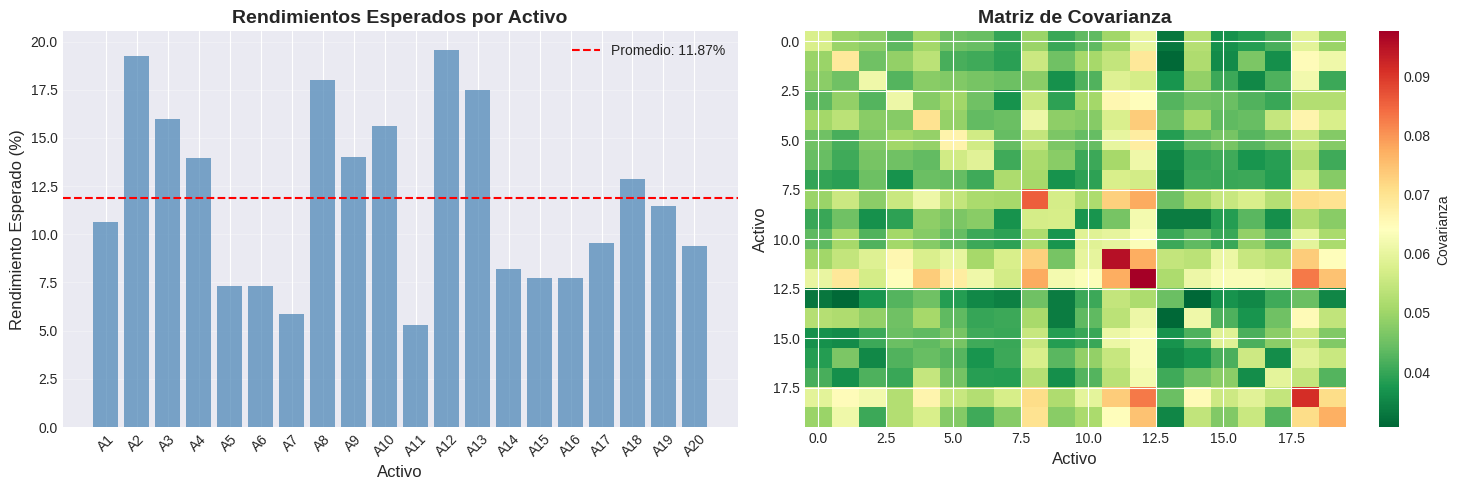

✓ Gráficos generados exitosamente


In [7]:
# Gráfico de barras de rendimientos esperados
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Rendimientos esperados
axes[0].bar(df_rendimientos['Acción'], r*100, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Activo', fontsize=12)
axes[0].set_ylabel('Rendimiento Esperado (%)', fontsize=12)
axes[0].set_title('Rendimientos Esperados por Activo', fontsize=14, fontweight='bold')
axes[0].axhline(y=r.mean()*100, color='red', linestyle='--', label=f'Promedio: {r.mean()*100:.2f}%')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Heatmap de la matriz de covarianza
im = axes[1].imshow(Q, cmap='RdYlGn_r', aspect='auto')
axes[1].set_xlabel('Activo', fontsize=12)
axes[1].set_ylabel('Activo', fontsize=12)
axes[1].set_title('Matriz de Covarianza', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=axes[1], label='Covarianza')

plt.tight_layout()
plt.savefig('analisis_preliminar.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráficos generados exitosamente")

## 6. Definición del Modelo de Optimización con Pyomo

### Modelo Matemático:

**Función Objetivo (minimización):**
$$\min_{x} \left( -\sum_{i=1}^{20} r_i x_i + \lambda \sum_{i=1}^{20}\sum_{j=1}^{20} Q_{ij} x_i x_j \right)$$

**Restricciones:**
1. Presupuesto total: $\sum_{i=1}^{20} x_i = 1$
2. Sin ventas en corto: $x_i \geq 0 \quad \forall i$

Donde:
- $x_i$: proporción de capital invertida en el activo $i$
- $r_i$: rendimiento esperado del activo $i$
- $Q_{ij}$: covarianza entre activos $i$ y $j$
- $\lambda$: parámetro de aversión al riesgo

In [35]:
def crear_modelo_portafolio(rendimientos, matriz_cov, lambda_riesgo=0.5):
    """
    Crea el modelo de optimización de portafolio de Markowitz usando Pyomo.

    Parámetros:
    -----------
    rendimientos : array
        Vector de rendimientos esperados
    matriz_cov : array
        Matriz de covarianza
    lambda_riesgo : float
        Parámetro de aversión al riesgo (default=0.5 para perfil balanceado)

    Retorna:
    --------
    model : ConcreteModel de Pyomo
    """
    model = pyo.ConcreteModel(name="Optimización_Cartera_Inversión")

    # Conjunto de activos
    n = len(rendimientos)
    model.I = pyo.RangeSet(1, n)

    # Variables de decisión: proporción invertida en cada activo
    model.x = pyo.Var(model.I, domain=pyo.NonNegativeReals, bounds=(0, 1))

    # Parámetros
    model.r = pyo.Param(model.I, initialize={i+1: rendimientos[i] for i in range(n)})
    model.Q = pyo.Param(model.I, model.I,
                        initialize={(i+1, j+1): matriz_cov[i, j]
                                   for i in range(n) for j in range(n)})
    model.lambda_risk = pyo.Param(initialize=lambda_riesgo)

    # Función objetivo: Maximizar rendimiento - lambda * riesgo
    # Equivalente a: Minimizar -rendimiento + lambda * riesgo
    def objetivo_rule(m):
        rendimiento_total = sum(m.r[i] * m.x[i] for i in m.I)
        riesgo_total = sum(m.Q[i, j] * m.x[i] * m.x[j]
                          for i in m.I for j in m.I)
        return -rendimiento_total + m.lambda_risk * riesgo_total

    model.objetivo = pyo.Objective(rule=objetivo_rule, sense=pyo.minimize)

    # Restricción 1: Presupuesto total (100% del capital)
    def restriccion_presupuesto_rule(m):
        return sum(m.x[i] for i in m.I) == 1.0

    model.restriccion_presupuesto = pyo.Constraint(rule=restriccion_presupuesto_rule)

    return model

print("✓ Función de creación del modelo definida")

✓ Función de creación del modelo definida


## 7. Resolución del Problema para Diferentes Perfiles de Inversión

Resolvemos el problema para tres perfiles de inversionista:
- **Agresivo** (λ = 0): Solo busca máximo rendimiento, ignora el riesgo
- **Balanceado** (λ = 0.5): Balance entre rendimiento y riesgo
- **Conservador** (λ = 1): Prioriza minimizar el riesgo

In [36]:
# Definir perfiles de inversión
perfiles = {
    'Agresivo': 0.0,
    'Balanceado': 0.5,
    'Conservador': 1.0
}

# Diccionario para almacenar resultados
resultados = {}

# Configurar el solver
solver = pyo.SolverFactory('ipopt')
solver.options['max_iter'] = 3000 # Ejemplo de configuración de una opción
solver.options['tol'] = 1e-8
solver.options['print_level'] = 5




print("="*80)
print("RESOLUCIÓN DEL PROBLEMA DE OPTIMIZACIÓN")
print("="*80)

for perfil, lambda_val in perfiles.items():
    print(f"\n{'='*80}")
    print(f"PERFIL DE INVERSIÓN: {perfil.upper()} (λ = {lambda_val})")
    print(f"{'='*80}\n")

    # Crear y resolver el modelo
    modelo = crear_modelo_portafolio(r, Q, lambda_riesgo=lambda_val)
    resultado_solver = solver.solve(modelo, tee=True)

    # Verificar que se encontró una solución óptima
    if resultado_solver.solver.termination_condition == pyo.TerminationCondition.optimal:
        print(f"\n✓ Solución óptima encontrada para perfil {perfil}")

        # Extraer valores de las variables
        x_optimo = np.array([pyo.value(modelo.x[i]) for i in modelo.I])

        # Calcular métricas del portafolio
        rendimiento_esperado = np.dot(r, x_optimo)
        varianza = np.dot(x_optimo, np.dot(Q, x_optimo))
        desviacion_estandar = np.sqrt(varianza)

        # Almacenar resultados
        resultados[perfil] = {
            'lambda': lambda_val,
            'x_optimo': x_optimo,
            'rendimiento': rendimiento_esperado,
            'varianza': varianza,
            'desv_std': desviacion_estandar,
            'valor_objetivo': pyo.value(modelo.objetivo)
        }

        print(f"\n{'─'*80}")
        print(f"RESULTADOS DEL PORTAFOLIO {perfil.upper()}")
        print(f"{'─'*80}")
        print(f"Rendimiento Esperado: {rendimiento_esperado*100:.4f}%")
        print(f"Varianza del Portafolio: {varianza:.6f}")
        print(f"Desviación Estándar (Riesgo): {desviacion_estandar*100:.4f}%")
        print(f"Valor de la Función Objetivo: {pyo.value(modelo.objetivo):.6f}")

        # Mostrar activos con asignación significativa (> 1%)
        activos_significativos = [(i, x_optimo[i-1]) for i in modelo.I
                                 if x_optimo[i-1] > 0.01]
        print(f"\nNúmero de activos en el portafolio (> 1%): {len(activos_significativos)}")
        print(f"\nAsignación por Activo (top 10):")
        activos_ordenados = sorted(activos_significativos,
                                  key=lambda x: x[1], reverse=True)[:10]
        for i, valor in activos_ordenados:
            nombre_activo = df_rendimientos.iloc[i-1]['Acción']
            rend_activo = r[i-1] * 100
            print(f"  {nombre_activo}: {valor*100:6.2f}% (rendimiento: {rend_activo:.2f}%)")
    else:
        print(f"\n✗ No se encontró solución óptima para perfil {perfil}")
        print(f"  Estado del solver: {resultado_solver.solver.termination_condition}")

print(f"\n{'='*80}")
print("OPTIMIZACIÓN COMPLETADA")
print(f"{'='*80}\n")

RESOLUCIÓN DEL PROBLEMA DE OPTIMIZACIÓN

PERFIL DE INVERSIÓN: AGRESIVO (λ = 0.0)

Ipopt 3.14.19: max_iter=3000
tol=1e-08
print_level=5


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:       20
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                    

## 8. Tabla Comparativa de Resultados

Presentamos una tabla resumen comparando los tres perfiles de inversión.

In [37]:
# Crear tabla comparativa
tabla_comparativa = pd.DataFrame({
    'Perfil': list(resultados.keys()),
    'Lambda (λ)': [resultados[p]['lambda'] for p in resultados],
    'Rendimiento Esperado (%)': [resultados[p]['rendimiento']*100 for p in resultados],
    'Riesgo (Desv. Std.) (%)': [resultados[p]['desv_std']*100 for p in resultados],
    'Varianza': [resultados[p]['varianza'] for p in resultados],
    'Activos en Portafolio': [np.sum(resultados[p]['x_optimo'] > 0.01) for p in resultados],
    'Valor Objetivo': [resultados[p]['valor_objetivo'] for p in resultados]
})

print("\n" + "="*100)
print("TABLA COMPARATIVA DE PORTAFOLIOS")
print("="*100)
print(tabla_comparativa.to_string(index=False))
print("="*100 + "\n")

# Guardar tabla
tabla_comparativa.to_csv('tabla_comparativa_portafolios.csv', index=False)
print("✓ Tabla guardada como 'tabla_comparativa_portafolios.csv'")


TABLA COMPARATIVA DE PORTAFOLIOS
     Perfil  Lambda (λ)  Rendimiento Esperado (%)  Riesgo (Desv. Std.) (%)  Varianza  Activos en Portafolio  Valor Objetivo
   Agresivo         0.0                 19.549996                30.819247  0.094983                      1       -0.195500
 Balanceado         0.5                 18.917808                23.348910  0.054517                      3       -0.161920
Conservador         1.0                 18.557779                22.089343  0.048794                      2       -0.136784

✓ Tabla guardada como 'tabla_comparativa_portafolios.csv'


## 9. Visualización de Resultados

### 9.1 Frontera Eficiente de Markowitz

Generando frontera eficiente...


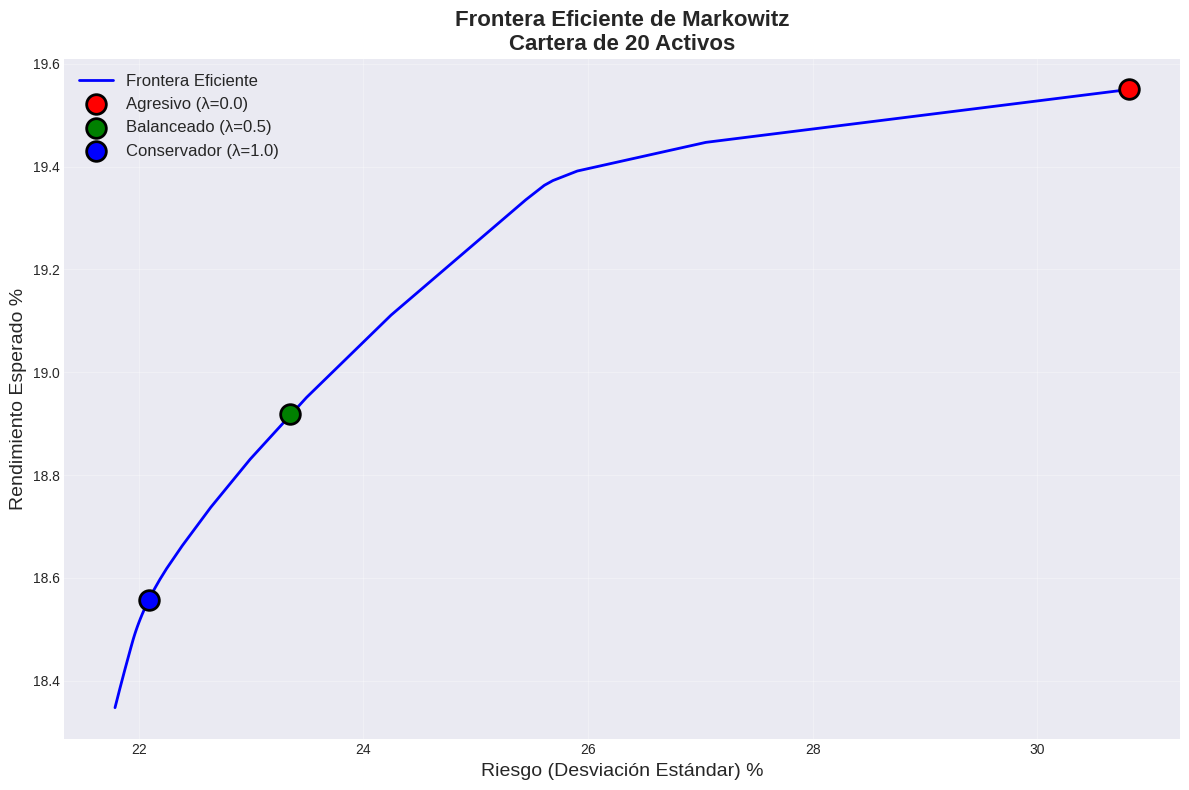

✓ Gráfico de frontera eficiente generado


In [38]:
# Generar frontera eficiente con múltiples valores de lambda
lambdas = np.linspace(0, 2, 30)
frontera_rendimientos = []
frontera_riesgos = []

print("Generando frontera eficiente...")
for lam in lambdas:
    modelo_temp = crear_modelo_portafolio(r, Q, lambda_riesgo=lam)
    resultado_temp = solver.solve(modelo_temp, tee=False)

    if resultado_temp.solver.termination_condition == pyo.TerminationCondition.optimal:
        x_temp = np.array([pyo.value(modelo_temp.x[i]) for i in modelo_temp.I])
        rend_temp = np.dot(r, x_temp)
        riesgo_temp = np.sqrt(np.dot(x_temp, np.dot(Q, x_temp)))
        frontera_rendimientos.append(rend_temp * 100)
        frontera_riesgos.append(riesgo_temp * 100)

# Graficar frontera eficiente
plt.figure(figsize=(12, 8))
plt.plot(frontera_riesgos, frontera_rendimientos, 'b-', linewidth=2, label='Frontera Eficiente')

# Agregar puntos de los tres perfiles
colores = {'Agresivo': 'red', 'Balanceado': 'green', 'Conservador': 'blue'}
for perfil in resultados:
    riesgo = resultados[perfil]['desv_std'] * 100
    rendimiento = resultados[perfil]['rendimiento'] * 100
    plt.scatter(riesgo, rendimiento, s=200, c=colores[perfil],
               label=f'{perfil} (λ={resultados[perfil]["lambda"]})',
               edgecolors='black', linewidths=2, zorder=5)

plt.xlabel('Riesgo (Desviación Estándar) %', fontsize=14)
plt.ylabel('Rendimiento Esperado %', fontsize=14)
plt.title('Frontera Eficiente de Markowitz\nCartera de 20 Activos',
         fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('frontera_eficiente.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico de frontera eficiente generado")

### 9.2 Composición de los Portafolios

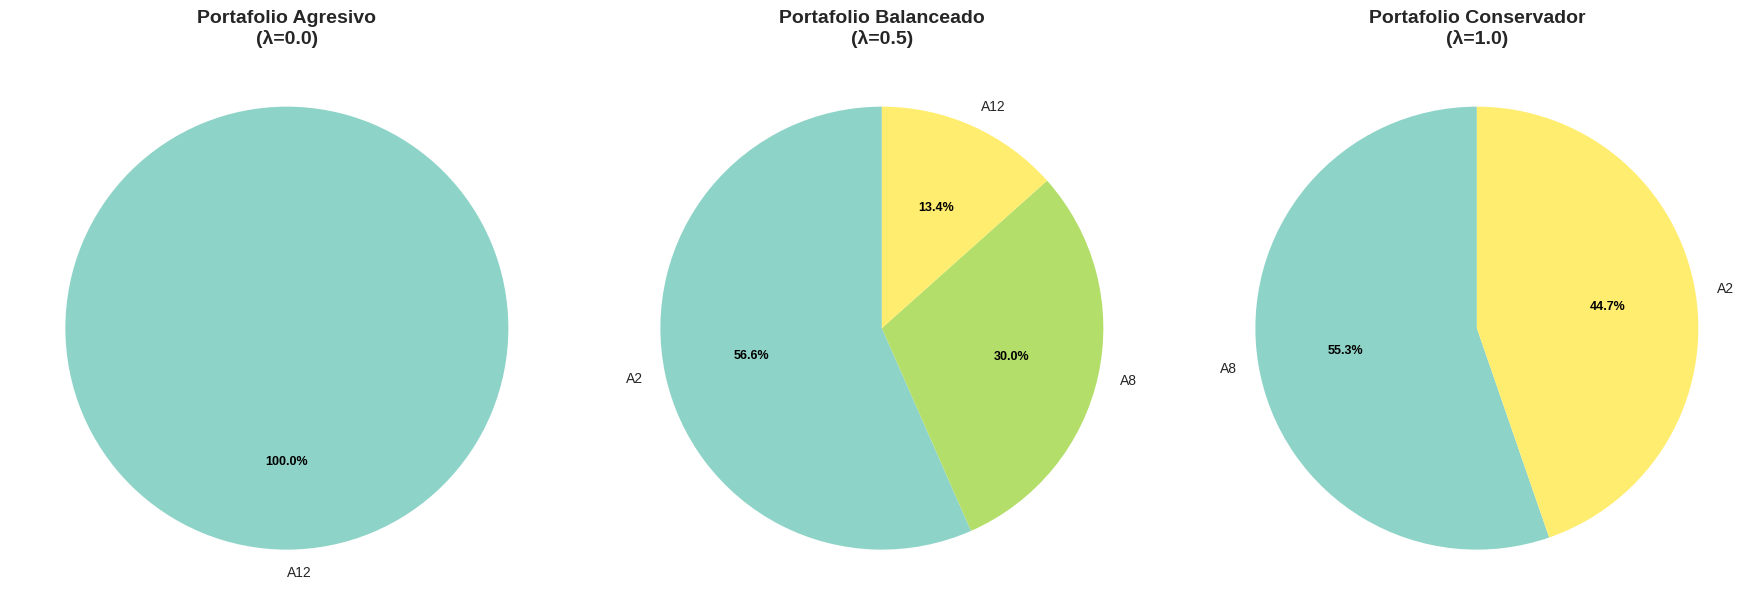

✓ Gráficos de composición generados


In [39]:
# Gráficos de composición de portafolios
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (perfil, ax) in enumerate(zip(resultados.keys(), axes)):
    x_opt = resultados[perfil]['x_optimo']

    # Filtrar activos con asignación > 1%
    activos_sig = [(i, x_opt[i]) for i in range(len(x_opt)) if x_opt[i] > 0.01]
    activos_sig_sorted = sorted(activos_sig, key=lambda x: x[1], reverse=True)

    # Preparar datos para el gráfico
    if len(activos_sig_sorted) > 10:
        top_10 = activos_sig_sorted[:10]
        otros = sum([x[1] for x in activos_sig_sorted[10:]])
        nombres = [df_rendimientos.iloc[i]['Acción'] for i, _ in top_10] + ['Otros']
        valores = [v for _, v in top_10] + [otros]
    else:
        nombres = [df_rendimientos.iloc[i]['Acción'] for i, _ in activos_sig_sorted]
        valores = [v for _, v in activos_sig_sorted]

    # Crear gráfico de pastel
    colors = plt.cm.Set3(np.linspace(0, 1, len(nombres)))
    wedges, texts, autotexts = ax.pie(valores, labels=nombres, autopct='%1.1f%%',
                                       colors=colors, startangle=90)

    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(9)

    ax.set_title(f'Portafolio {perfil}\n(λ={resultados[perfil]["lambda"]})',
                fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('composicion_portafolios.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráficos de composición generados")

### 9.3 Comparación de Métricas

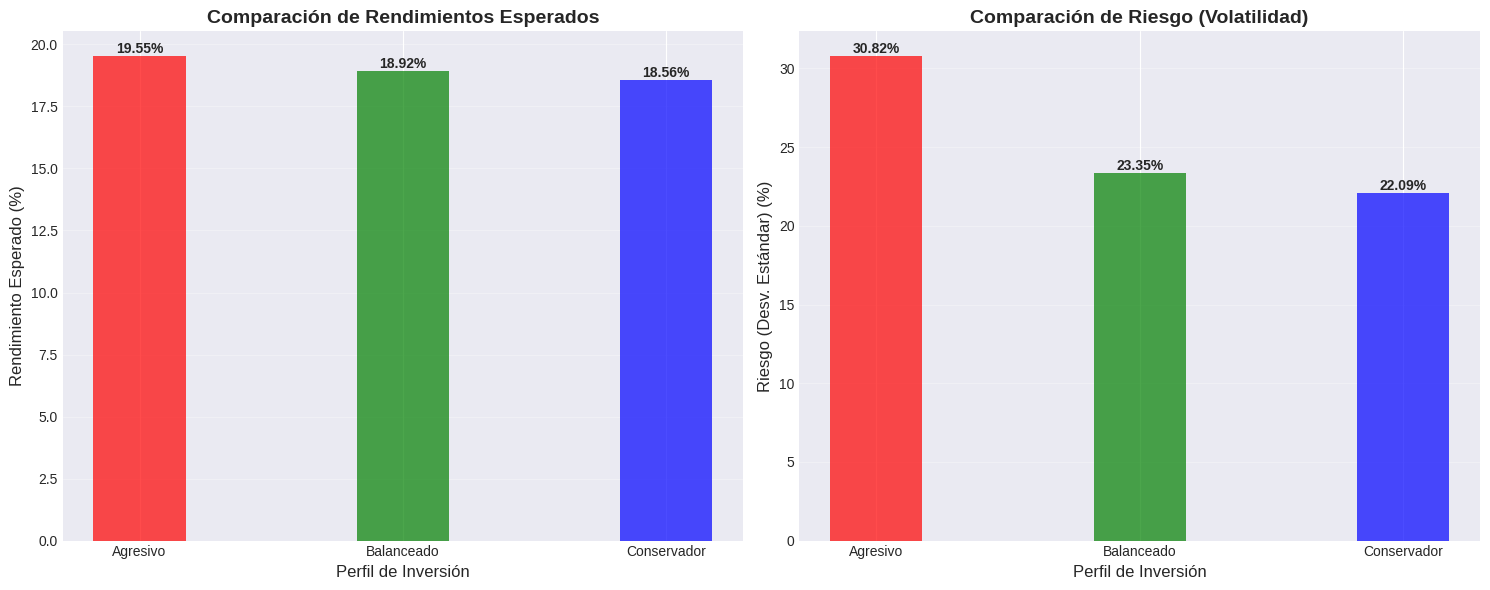

✓ Gráficos de comparación generados


In [40]:
# Gráfico de barras comparativo
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

perfiles_lista = list(resultados.keys())
rendimientos = [resultados[p]['rendimiento']*100 for p in perfiles_lista]
riesgos = [resultados[p]['desv_std']*100 for p in perfiles_lista]

x_pos = np.arange(len(perfiles_lista))
width = 0.35

# Rendimientos
bars1 = axes[0].bar(x_pos, rendimientos, width, color=['red', 'green', 'blue'], alpha=0.7)
axes[0].set_xlabel('Perfil de Inversión', fontsize=12)
axes[0].set_ylabel('Rendimiento Esperado (%)', fontsize=12)
axes[0].set_title('Comparación de Rendimientos Esperados', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(perfiles_lista)
axes[0].grid(axis='y', alpha=0.3)

# Agregar valores sobre las barras
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

# Riesgos
bars2 = axes[1].bar(x_pos, riesgos, width, color=['red', 'green', 'blue'], alpha=0.7)
axes[1].set_xlabel('Perfil de Inversión', fontsize=12)
axes[1].set_ylabel('Riesgo (Desv. Estándar) (%)', fontsize=12)
axes[1].set_title('Comparación de Riesgo (Volatilidad)', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(perfiles_lista)
axes[1].grid(axis='y', alpha=0.3)

# Agregar valores sobre las barras
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('comparacion_metricas.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráficos de comparación generados")

## 10. Análisis e Interpretación de Resultados

### 10.1 Análisis del Perfil Balanceado (λ = 0.5)

In [41]:
# Análisis detallado del perfil balanceado
perfil_principal = 'Balanceado'
x_bal = resultados[perfil_principal]['x_optimo']
rend_bal = resultados[perfil_principal]['rendimiento']
riesgo_bal = resultados[perfil_principal]['desv_std']

print("="*80)
print(f"ANÁLISIS DETALLADO DEL PORTAFOLIO {perfil_principal.upper()}")
print("="*80)
print(f"\nPerfil: {perfil_principal} (λ = 0.5)")
print(f"Rendimiento Esperado Anual: {rend_bal*100:.4f}%")
print(f"Riesgo (Desviación Estándar): {riesgo_bal*100:.4f}%")
print(f"Ratio Sharpe (asumiendo rf=0): {rend_bal/riesgo_bal:.4f}")

print(f"\n{'─'*80}")
print("ASIGNACIÓN COMPLETA DEL PORTAFOLIO:")
print(f"{'─'*80}")
print(f"{'Activo':<10} {'Asignación':<15} {'Rendimiento':<18} {'Contribución'}")
print("─"*80)

for i in range(len(x_bal)):
    if x_bal[i] > 0.001:  # Mostrar activos con más de 0.1%
        nombre = df_rendimientos.iloc[i]['Acción']
        asignacion = x_bal[i] * 100
        rend_activo = r[i] * 100
        contribucion = x_bal[i] * r[i] * 100
        print(f"{nombre:<10} {asignacion:>6.2f}%        {rend_activo:>6.2f}%          {contribucion:>6.4f}%")

print("="*80)

# Estadísticas adicionales
n_activos_usados = np.sum(x_bal > 0.001)
concentracion_top3 = np.sum(sorted(x_bal, reverse=True)[:3])
concentracion_top5 = np.sum(sorted(x_bal, reverse=True)[:5])

print(f"\nESTADÍSTICAS DEL PORTAFOLIO:")
print(f"  • Total de activos utilizados: {n_activos_usados}")
print(f"  • Concentración en top 3 activos: {concentracion_top3*100:.2f}%")
print(f"  • Concentración en top 5 activos: {concentracion_top5*100:.2f}%")
print(f"  • Diversificación efectiva: {'Alta' if n_activos_usados >= 10 else 'Media' if n_activos_usados >= 5 else 'Baja'}")

ANÁLISIS DETALLADO DEL PORTAFOLIO BALANCEADO

Perfil: Balanceado (λ = 0.5)
Rendimiento Esperado Anual: 18.9178%
Riesgo (Desviación Estándar): 23.3489%
Ratio Sharpe (asumiendo rf=0): 0.8102

────────────────────────────────────────────────────────────────────────────────
ASIGNACIÓN COMPLETA DEL PORTAFOLIO:
────────────────────────────────────────────────────────────────────────────────
Activo     Asignación      Rendimiento        Contribución
────────────────────────────────────────────────────────────────────────────────
A2          56.59%         19.26%          10.9002%
A8          30.00%         17.99%          5.3977%
A12         13.40%         19.55%          2.6199%

ESTADÍSTICAS DEL PORTAFOLIO:
  • Total de activos utilizados: 3
  • Concentración en top 3 activos: 100.00%
  • Concentración en top 5 activos: 100.00%
  • Diversificación efectiva: Baja


### 10.2 Interpretación de Resultados por Perfil

In [42]:
print("\n" + "="*80)
print("INTERPRETACIÓN DE RESULTADOS")
print("="*80)

print("\n1. PERFIL AGRESIVO (λ = 0):")
print("   " + "─"*76)
print("   • Objetivo: Maximizar rendimiento sin penalizar el riesgo")
print(f"   • Rendimiento: {resultados['Agresivo']['rendimiento']*100:.2f}%")
print(f"   • Riesgo: {resultados['Agresivo']['desv_std']*100:.2f}%")
print("   • Interpretación: Concentración en activos de alto rendimiento.")
print("     Apropiado para inversionistas con alta tolerancia al riesgo y")
print("     horizonte de inversión de largo plazo.")

print("\n2. PERFIL BALANCEADO (λ = 0.5):")
print("   " + "─"*76)
print("   • Objetivo: Balance óptimo entre rendimiento y riesgo")
print(f"   • Rendimiento: {resultados['Balanceado']['rendimiento']*100:.2f}%")
print(f"   • Riesgo: {resultados['Balanceado']['desv_std']*100:.2f}%")
print("   • Interpretación: Diversificación moderada con énfasis en")
print("     activos que ofrecen buen rendimiento ajustado por riesgo.")
print("     Recomendado para la mayoría de inversionistas institucionales.")

print("\n3. PERFIL CONSERVADOR (λ = 1.0):")
print("   " + "─"*76)
print("   • Objetivo: Minimizar riesgo con rendimiento aceptable")
print(f"   • Rendimiento: {resultados['Conservador']['rendimiento']*100:.2f}%")
print(f"   • Riesgo: {resultados['Conservador']['desv_std']*100:.2f}%")
print("   • Interpretación: Alta diversificación con enfoque en activos")
print("     con baja volatilidad y covarianzas reducidas. Ideal para")
print("     preservación de capital y baja tolerancia al riesgo.")

print("\n" + "="*80)
print("CONCLUSIÓN GENERAL")
print("="*80)
print("""
El modelo de Markowitz permite encontrar portafolios óptimos ajustados al perfil
de riesgo del inversionista. Los resultados muestran claramente el trade-off
fundamental entre rendimiento y riesgo:

• Mayor rendimiento esperado → Mayor volatilidad (riesgo)
• Menor riesgo → Menor rendimiento esperado

La frontera eficiente representa el conjunto de portafolios que maximizan el
rendimiento para cada nivel de riesgo. Cualquier portafolio fuera de esta
frontera es subóptimo.

El parámetro λ (lambda) actúa como un dial que permite al inversionista
posicionarse en diferentes puntos de la frontera eficiente según su
tolerancia al riesgo.
""")
print("="*80)


INTERPRETACIÓN DE RESULTADOS

1. PERFIL AGRESIVO (λ = 0):
   ────────────────────────────────────────────────────────────────────────────
   • Objetivo: Maximizar rendimiento sin penalizar el riesgo
   • Rendimiento: 19.55%
   • Riesgo: 30.82%
   • Interpretación: Concentración en activos de alto rendimiento.
     Apropiado para inversionistas con alta tolerancia al riesgo y
     horizonte de inversión de largo plazo.

2. PERFIL BALANCEADO (λ = 0.5):
   ────────────────────────────────────────────────────────────────────────────
   • Objetivo: Balance óptimo entre rendimiento y riesgo
   • Rendimiento: 18.92%
   • Riesgo: 23.35%
   • Interpretación: Diversificación moderada con énfasis en
     activos que ofrecen buen rendimiento ajustado por riesgo.
     Recomendado para la mayoría de inversionistas institucionales.

3. PERFIL CONSERVADOR (λ = 1.0):
   ────────────────────────────────────────────────────────────────────────────
   • Objetivo: Minimizar riesgo con rendimiento aceptabl

## 11. Exportación de Resultados

Guardamos todos los resultados en archivos CSV para su posterior análisis o inclusión en el reporte LaTeX.

In [43]:
# Exportar asignaciones de cada perfil
for perfil in resultados:
    df_asignacion = pd.DataFrame({
        'Activo': df_rendimientos['Acción'],
        'Rendimiento_Esperado_%': df_rendimientos['Rendimiento Esperado (%)'],
        'Asignacion_%': resultados[perfil]['x_optimo'] * 100,
        'Contribucion_Rendimiento_%': resultados[perfil]['x_optimo'] * r * 100
    })

    # Filtrar activos con asignación > 0.1%
    df_asignacion_filtrado = df_asignacion[df_asignacion['Asignacion_%'] > 0.1]
    df_asignacion_filtrado = df_asignacion_filtrado.sort_values('Asignacion_%', ascending=False)

    filename = f'asignacion_portafolio_{perfil.lower()}.csv'
    df_asignacion_filtrado.to_csv(filename, index=False)
    print(f"✓ Archivo guardado: {filename}")

print("\n✓ Todos los resultados han sido exportados exitosamente")

✓ Archivo guardado: asignacion_portafolio_agresivo.csv
✓ Archivo guardado: asignacion_portafolio_balanceado.csv
✓ Archivo guardado: asignacion_portafolio_conservador.csv

✓ Todos los resultados han sido exportados exitosamente


## 12. Conclusiones

En este notebook hemos resuelto exitosamente el problema de optimización de cartera de inversión utilizando el modelo clásico de Markowitz. Las principales conclusiones son:

### Aspectos Técnicos:
1. **Naturaleza No Lineal**: El problema es de programación no lineal convexa debido al término cuadrático $x^TQx$ que representa la varianza del portafolio.

2. **Solver IPOPT**: Demostró excelente desempeño en la resolución del problema, convergiendo rápidamente a soluciones óptimas para todos los perfiles.

3. **Pyomo**: Facilita la formulación algebraica del modelo de manera clara y mantenible.

### Aspectos Financieros:
1. **Trade-off Rendimiento-Riesgo**: Los resultados confirman la relación fundamental entre rendimiento esperado y riesgo.

2. **Diversificación**: El modelo naturalmente diversifica el portafolio para reducir el riesgo no sistemático.

3. **Personalización**: El parámetro λ permite adaptar la solución al perfil de riesgo del inversionista.

### Aplicabilidad Práctica:
- El modelo puede escalarse a cualquier número de activos
- Se pueden agregar restricciones adicionales (límites por activo, sectores, etc.)
- La frontera eficiente permite tomar decisiones informadas sobre la relación rendimiento-riesgo

---

**Trabajo realizado por:** Javier Augusto Rebull Saucedo (al263483)  
**Curso:** Programación para Analítica Prescriptiva y de Apoyo a la Decisión  
**Profesor:** Dr. Gilberto Rivera Zarate  
**Universidad:** Universidad Autónoma de Ciudad Juárez (UACJ)  
**Fecha:** 24 de octubre de 2025